In [3]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import pickle 
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *

from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

# Table of Contents:
* [Check position jetter](#pbps_noise)
* [Load PSSS vs time](#psss_com)


<a id='pbps_noise'></a>
## Position jitter

In [134]:
pgroup='p21208'
runnumber = 131
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0131


'/sf/alvra/data/p21208/raw/run0131-ocp_ech_1us_7um_5mJmm2/meta/scan.json'

In [135]:
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan

SFScanInfo("/sf/alvra/data/p21208/raw/run0131-ocp_ech_1us_7um_5mJmm2/meta/scan.json"): 7 steps

In [136]:
channel_list = [channel_posX_110, channel_posY_110]

#################################################

all_results = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    check = get_filesize_diff(step) 
    if check:
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

        results,pids = load_data_compact(channel_list, step)
        
        all_results.append(results)

Step 7 of 7: Processing acq0007

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet 2807 / 2807 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:XPOS    2768 / 2807 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:YPOS    2768 / 2807 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 2768 / 2807 -> 1% loss
complete channels: 1 / 3 -> 67% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [137]:
xpos = []
ypos = []
for index in range(len(all_results)):
    xpos.extend(all_results[index][channel_posX_110])
    ypos.extend(all_results[index][channel_posY_110])
xpos = np.asarray(xpos)
ypos = np.asarray(ypos)
len(xpos)

32491

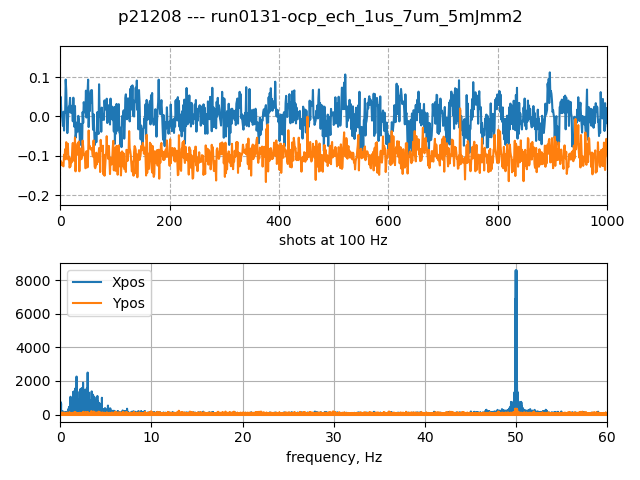

In [152]:
#x=np.arange(0,100,0.05)
x = np.linspace(0,100,len(xpos)*2)
valsdiode = np.hstack((xpos-np.mean(xpos), np.zeros_like(xpos)))
vals2diode = np.hstack((ypos - np.mean(ypos), np.zeros_like(ypos)))
powerx = np.abs(np.fft.fft(valsdiode))**2
powery = np.abs(np.fft.fft(vals2diode))**2

fig, axs = plt.subplots(2, 1)
plt.suptitle(titlestring)
axs[0].plot(valsdiode)
axs[0].plot(vals2diode-0.1)
#axs[0].set_xlim(0,len(xpos))
axs[0].set_xlim(0,1000)
axs[0].set_xlabel('shots at 100 Hz')
axs[0].grid(True, linestyle='--')

axs[1].plot(x, powerx, label ="Xpos")
axs[1].plot(x, powery, label ="Ypos")
axs[1].set_xlabel('frequency, Hz')
axs[1].set_xlim(0,60)
plt.legend(loc='best')
#axs[1].set_ylim(0,100)
axs[1].grid(True)
fig.tight_layout()
plt.show()

<a id='psss_com'></a>
## check PSSS com vs time

In [8]:
def timestamp(json_file):
    file_split = json_file.split('/')[:-1]
    path_to_bsdata = '/'.join([*file_split[:-1], 'data', '*BSDATA.h5'])
    
    timestamp_s = []
    
    for file in glob.glob(path_to_bsdata):
        with h5py.File(file) as f:
            timestamp_ns = f[channel_Events]['timestamp'][:]
            timestamp_s.append(np.mean(timestamp_ns) * 1e-9)
    timestamp_s = np.mean(timestamp_s)
    timestamp_datetime = datetime.fromtimestamp(timestamp_s)
    return np.datetime64(timestamp_datetime)

def timestamp_step(step):
    bsdata = step.fnames[0]
    timestamp_s = []
    with h5py.File(bsdata) as f:
        timestamp_ns = f[channel_Events]['timestamp'][:]
        timestamp_s.append(np.mean(timestamp_ns) * 1e-9)
    timestamp_s = np.mean(timestamp_s)
    timestamp_datetime = datetime.fromtimestamp(timestamp_s)
    return np.datetime64(timestamp_datetime)

In [153]:
pgroup = 'p21208'
reducedir='../Claudio/Reduced_data/'

runlist = np.arange(134, 149, 1)

datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob('/sf/alvra/data/p21208/raw/*{:04d}*/meta/scan.json'.format(run))
    datafiles.extend(file)
#datafiles    


[134 135 136 137 138 139 140 141 142 143 144 145 146 147 148]


In [154]:
channel_list = ['SARFE10-PSSS059:FIT-COM', "SARFE10-PBPG050:HAMP-INTENSITY-CAL"]

#################################################
from sfdata import SFScanInfo

all_results = []
psss_com = []
timestamps_npy = []
pulseEnergy = []
timestamps = []

for j,json_file in enumerate(datafiles):
    scan = SFScanInfo(json_file)
    psss_com_run=[]
    pulseEnergy_run = []
    timestamps_run = []
    for i, step in enumerate(scan):
        check_files_and_data(step)
        check = get_filesize_diff(step) 
        if check:
            clear_output(wait=True)
            print ('{}/{}: {}'.format(j+1, len(datafiles), json_file))
            timestamps_run.append( timestamp_step(step) )
            filename = scan.files[i][0].split('/')[-1].split('.')[0]
            print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

            results,pids = load_data_compact(channel_list, step)
            temp = results['SARFE10-PSSS059:FIT-COM']
            psss_com_run.append(np.average(results['SARFE10-PSSS059:FIT-COM']))
            psss_com.append(np.average(results['SARFE10-PSSS059:FIT-COM']))
            
            pulseEnergy.append(np.average(results["SARFE10-PBPG050:HAMP-INTENSITY-CAL"]))
            pulseEnergy_run.append(np.average(results["SARFE10-PBPG050:HAMP-INTENSITY-CAL"]))
            timestamps.append(timestamp_step(step))
            
            all_results.append(results)
            
        run_name = json_file.split('/')[-3]
        loaddata = reducedir+run_name
        os.makedirs(reducedir, exist_ok=True)
        data = {}
        data ={"psss": psss_com_run, "pulseEnergy": pulseEnergy_run, "timestamp": timestamps_run}
        with open(loaddata+'_data.pkl', 'wb') as f:
            pickle.dump(data, f)
#        np.save(loaddata+'_data', data)
 #       np.save(loaddata+'_pulseEnergy_data.npy', pulseEnergy_run)
 #       np.save(loaddata+'_timestamps.npy',timestamps_npy)

15/15: /sf/alvra/data/p21208/raw/run0148-ocp_ech_20ms_7um_5mJmm2/meta/scan.json
Step 4 of 4: Processing acq0004

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet            1958 / 1958 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PBPG050:HAMP-INTENSITY-CAL 1958 / 1958 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PSSS059:FIT-COM            1957 / 1958 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1957 / 1958 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


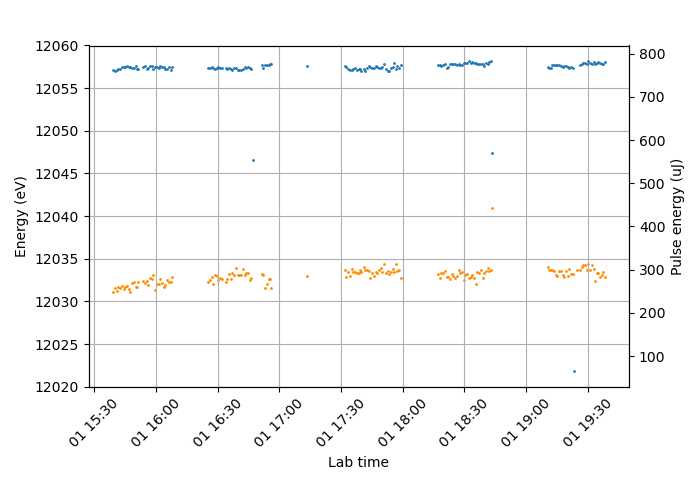

In [155]:
fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax1.scatter(timestamps, psss_com, color = 'darkorange', s=1)
ax2.scatter(timestamps, pulseEnergy, s=1)

ax1.tick_params('x', labelrotation=45)
ax1.set_ylabel('Energy (eV)')
ax2.set_ylabel('Pulse energy (uJ)')
ax1.set_xlabel('Lab time')
ax1.set_ylim(12020, 12060)

ax1.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [156]:
file = glob.glob('/sf/alvra/data/p21208/work/Claudio/Reduced_data/*data*.pkl')
file = np.sort(file)

psss_com = []
pulseEnergy = []
timestamps = []
for f in file:
    with open(f, 'rb') as ff:
        temp_dict = pickle.load(ff)
        psss_com.extend(temp_dict["psss"])
        pulseEnergy.extend(temp_dict["pulseEnergy"])
        timestamps.extend(temp_dict["timestamp"])
print (len(psss_com), len(pulseEnergy), len(timestamps))

2512 2512 2512


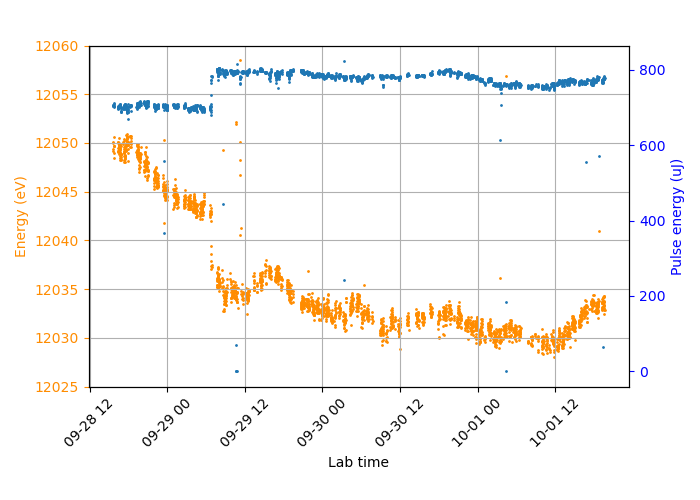

In [157]:
fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax1.scatter(timestamps, psss_com, color = 'darkorange', s=1)
ax2.scatter(timestamps, pulseEnergy, s=1)

# ax1.plot(psss_com, color = 'darkorange')
# ax2.plot(pulseEnergy)

ax1.tick_params('x', labelrotation=45)
ax1.set_ylabel('Energy (eV)')
ax1.yaxis.label.set_color('darkorange')
ax1.tick_params(axis='y', colors='darkorange')

ax2.set_ylabel('Pulse energy (uJ)')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

ax1.set_xlabel('Lab time')
ax1.set_ylim(12025, 12060)

ax1.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
bsread_file = fc.selected

channel_list = [channel_PSSS_x, channel_PSSS_y, channel_Izero122, channel_Izero117, channel_GasMonitor]

print ("Loading data from file {}".format(bsread_file))

results = load_data_compact(channel_list, bsread_file)
Data_PBPS122 = results[channel_Izero122]
Data_PBPS117 = results[channel_Izero117]
Data_GasM = results[channel_GasMonitor]
Data_PSSS = results[channel_PSSS_y]
Data_PSSS_Energy = results[channel_PSSS_x]


Loading data from file /gpfs/photonics/swissfel/raw/alvra-staff/p18389/TD1_1us_pump_dark/run_000915.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet            9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PBPG050:HAMP-INTENSITY-AVG 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PSSS059:SPECTRUM_X         9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PSSS059:SPECTRUM_Y         9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY          9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY          9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz


<IPython.core.display.Javascript object>


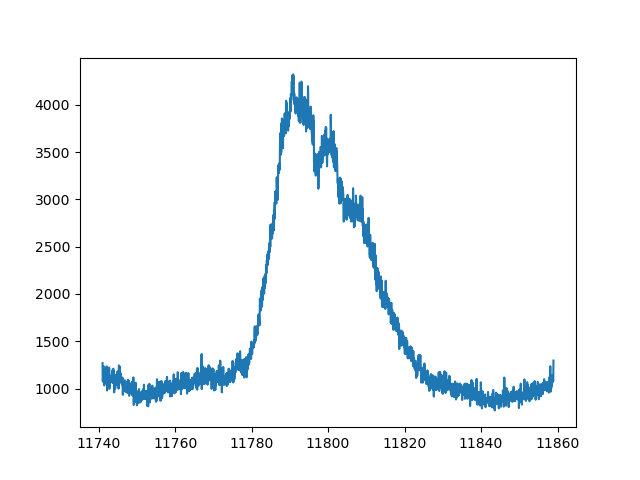

In [17]:
plt.figure()
plt.plot(Data_PSSS_Energy[0], Data_PSSS.mean(axis=0))
plt.show()

PBPS data have 5000 shots, avg intensity = 2.2189 +/- 0.4973
GasM data have 5000 shots, avg intensity = 4.6084 +/- 1.3576


<IPython.core.display.Javascript object>


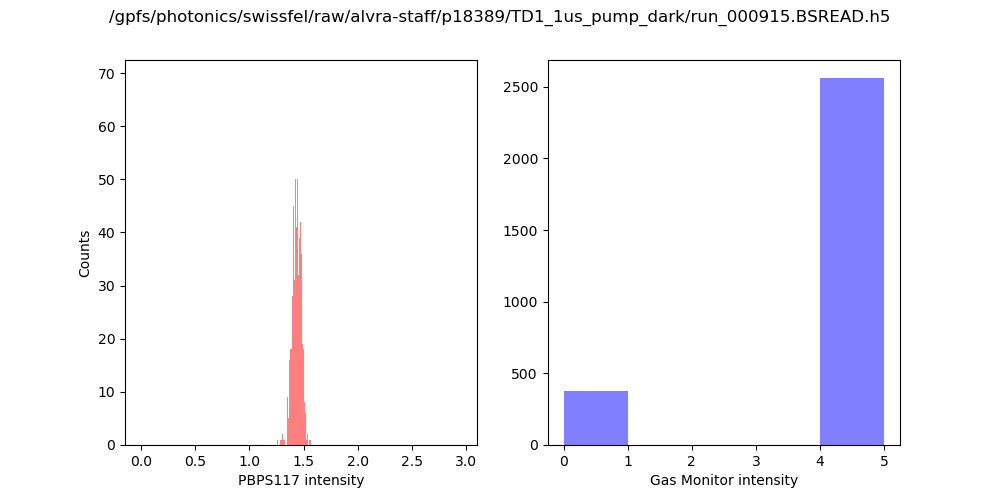

In [12]:
conditionGeneral = Data_PBPS117 > 0.0
Data_GasM_corr = Data_GasM[conditionGeneral]

print ("PBPS data have {} shots, avg intensity = {} +/- {}".format(len(Data_PBPS117),round(np.average(Data_PBPS117),4), round(np.std(Data_PBPS117),4)))
print ("GasM data have {} shots, avg intensity = {} +/- {}".format(len(Data_GasM),round(np.average(Data_GasM),4), round(np.std(Data_GasM),4)))

plt.figure(figsize = (10,5))

plt.suptitle(bsread_file, fontsize=12)
plt.subplot(1,2,1)
plt.hist(Data_PBPS122, bins =np.arange(0, np.max(Data_PBPS117),0.001), facecolor='red', alpha=0.5)
plt.ylabel ("Counts")
plt.xlabel("PBPS117 intensity")

plt.subplot(1,2,2)
plt.hist(Data_GasM, bins =np.arange(0,np.max(Data_GasM),1), facecolor='blue', alpha=0.5)

plt.xlabel("Gas Monitor intensity")
plt.show()
#print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

In [ ]:
!h5ls -d "/sf/alvra/data/p17589/res/OATT53_tests/20200225_motor5_pos-15_12kev.h5/SARFE10-PBPG050:HAMP-INTENSITY-CAL"


In [35]:
number_shots = []
for i in range(0,10):
    filename = DIR + scan_name + "_step000%s.BSREAD.h5" % i
    data, pid = load_single_channel(filename, channel_LaserDiode, 18)
    number_shots.append(len(data))
    
